In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.manifold import TSNE

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10, l_size=392, init_fn=nn.init.kaiming_normal_):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, l_size)
        init_fn(self.fc1.weight)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l_size, latent_size)
        init_fn(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10, l_size=392, init_fn=nn.init.xavier_uniform_):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, l_size)
        init_fn(self.fc1.weight)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l_size, 28*28)
        init_fn(self.fc2.weight)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = torch.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, l_size=392, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.l_size = l_size       
        self.E = Encoder(latent_size, l_size)
        self.D = Decoder(latent_size, l_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def encode(self, x):
        with torch.no_grad():
            x = x.view(-1, 28*28)
            return self.E(x)
        
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [5]:
def add_noise(x, mode='crop', elementwise=False):
#     if np.random.randint(2):
#         return x
    x = x.clone()
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            img_part = np.random.randint(4)
            if img_part == 0:
                x[:, :, :28, 14:] = torch.tensor(x[:, :, :28, :14].numpy()[:, :, :, ::-1].copy())
            elif img_part == 1:
                x[:, :, :28, :14] = torch.tensor(x[:, :, :28, 14:].numpy()[:, :, :, ::-1].copy())
            elif img_part == 2:
                x[:, :, 14:, :28] = torch.tensor(x[:, :, :14, :28].numpy()[:, :, ::-1, :].copy())
            elif img_part == 3:
                x[:, :, :14, :28] = torch.tensor(x[:, :, 14:, :28].numpy()[:, :, ::-1, :].copy())
        
        elif mode == 'gaussian':
            noise = nn.Parameter(x.new(x.size()).normal_())
            x = x + noise*0.1
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

In [6]:
def train(epoch, models, log=None, mode='crop', elementwise=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data, mode=mode, elementwise=elementwise)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward(retain_graph=True)
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)

def test(models, loader, log=None, mode='crop', elementwise=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data, mode=mode, elementwise=elementwise)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

### Models

In [8]:
models = {'2_392': Net(latent_size=2, l_size=392),
          '32_392': Net(latent_size=32, l_size=392),
          '2_1568': Net(latent_size=2, l_size=1568),
          '32_1568': Net(latent_size=32, l_size=1568)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [9]:
models

{'2_392': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=2, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=2, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=784, bias=True)
   )
 ), '32_392': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=32, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=32, out_features=392, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=392, out_features=784, bias=True)
   )
 ), '2_1568': Net(
   (E): Encoder(
     (fc1): Linear(in_features=784, out_features=1568, bias=True)
     (relu1): ReLU()
     (fc2): Linear(in_features=1568, out_features=2, bias=True)
   )
   (D): Decoder(
     (fc1): Linear(in_features=2, out_features=1568, bias=True)
     (r

# CROP
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = False
- mode = crop

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='crop', elementwise=False)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='crop', elementwise=False)

Train Epoch: 1 [00000/60000] 2_392: 0.976375 32_392: 0.950532 2_1568: 1.045553 32_1568: 0.936502
Train Epoch: 1 [30000/60000] 2_392: 0.326106 32_392: 0.265765 2_1568: 0.261907 32_1568: 0.258555
Train Epoch: 1 [60000/60000] 2_392: 0.287764 32_392: 0.268580 2_1568: 0.272687 32_1568: 0.257903
Test set:
2_392: loss: 0.2864
32_392: loss: 0.2678
2_1568: loss: 0.2715
32_1568: loss: 0.2586

Train Epoch: 2 [00000/60000] 2_392: 0.289998 32_392: 0.272336 2_1568: 0.275080 32_1568: 0.264432
Train Epoch: 2 [30000/60000] 2_392: 0.266677 32_392: 0.245743 2_1568: 0.255475 32_1568: 0.217642
Train Epoch: 2 [60000/60000] 2_392: 0.275674 32_392: 0.249626 2_1568: 0.258040 32_1568: 0.214289
Test set:
2_392: loss: 0.2725
32_392: loss: 0.2446
2_1568: loss: 0.2546
32_1568: loss: 0.2030

Train Epoch: 3 [00000/60000] 2_392: 0.282361 32_392: 0.252498 2_1568: 0.263308 32_1568: 0.206022
Train Epoch: 3 [30000/60000] 2_392: 0.263031 32_392: 0.235889 2_1568: 0.246626 32_1568: 0.205797
Train Epoch: 3 [60000/60000] 2_392

In [11]:
losses_df = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df['mode'].fillna('Crop', inplace=True)
losses_df['elementwise'].fillna('False', inplace=True)

losses_df['test loss'] = [0.2234, 0.1102, 0.2220, 0.0922]
losses_df

,mode,elementwise,"fc1(.., l_size)","fc2(.., latent_size)",test loss
0,Crop,False,392,2,0.2234
1,Crop,False,392,32,0.1102
2,Crop,False,1568,2,0.2220
3,Crop,False,1568,32,0.0922


### Noised

MODEL 2_392 Raw data


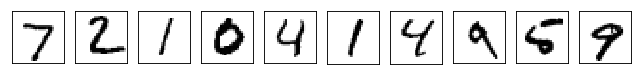

MODEL 2_392 Mirror


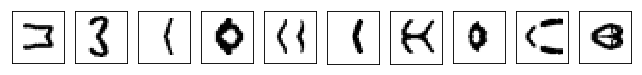

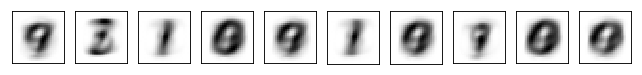

MODEL 2_392 Gaussian


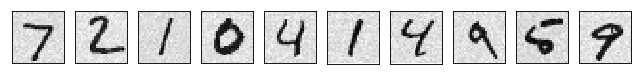

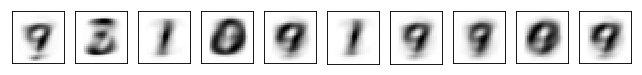

MODEL 2_392 Elementwise crop


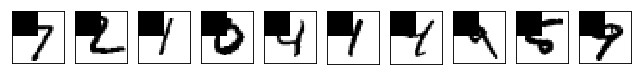

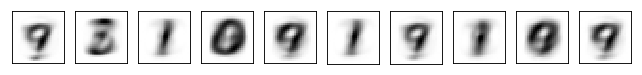

MODEL 2_392 Not elementwise crop


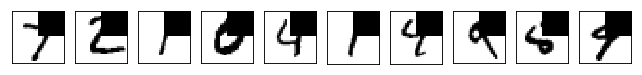

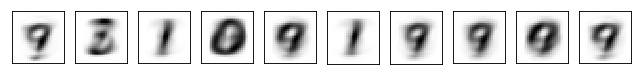

MODEL 32_392 Raw data


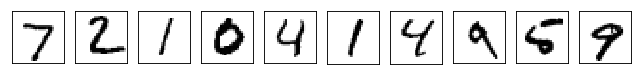

MODEL 32_392 Mirror


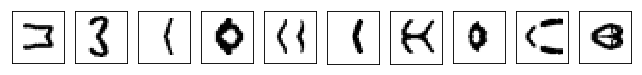

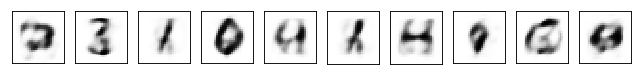

MODEL 32_392 Gaussian


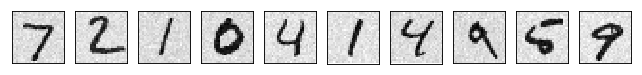

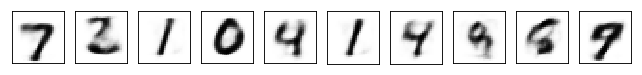

MODEL 32_392 Elementwise crop


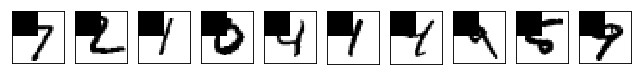

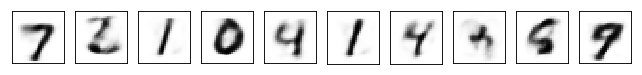

MODEL 32_392 Not elementwise crop


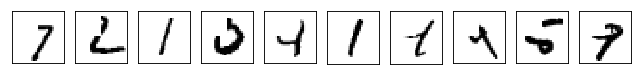

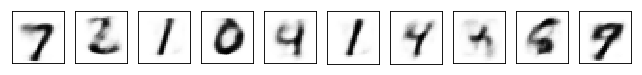

MODEL 2_1568 Raw data


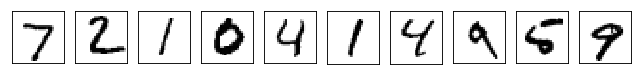

MODEL 2_1568 Mirror


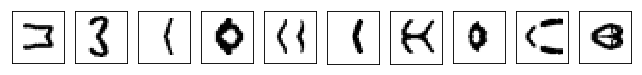

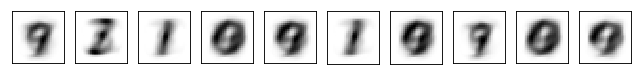

MODEL 2_1568 Gaussian


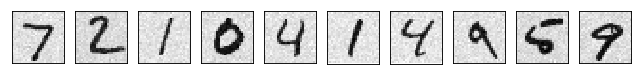

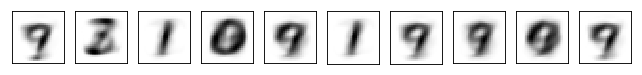

MODEL 2_1568 Elementwise crop


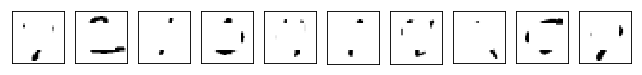

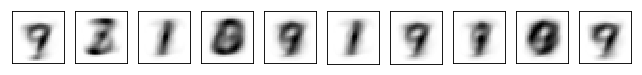

MODEL 2_1568 Not elementwise crop


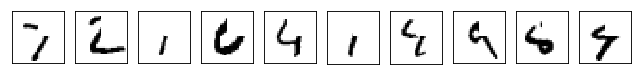

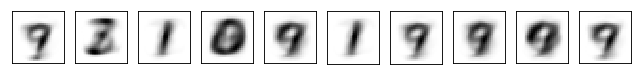

MODEL 32_1568 Raw data


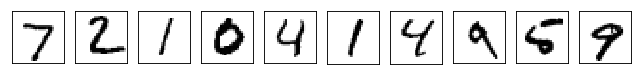

MODEL 32_1568 Mirror


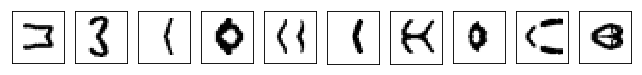

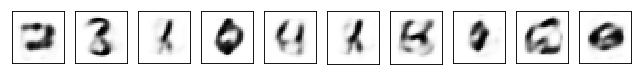

MODEL 32_1568 Gaussian


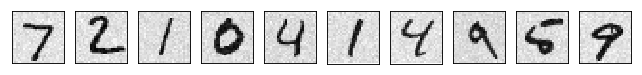

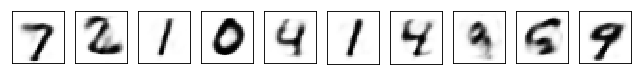

MODEL 32_1568 Elementwise crop


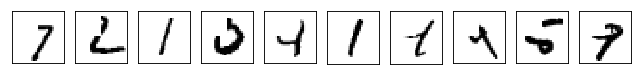

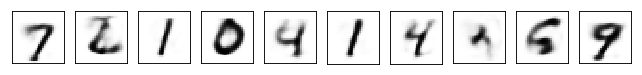

MODEL 32_1568 Not elementwise crop


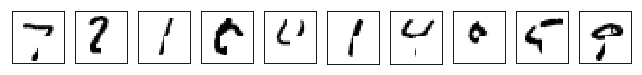

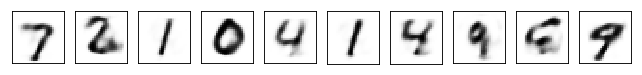

In [12]:
for m in models:
    print('MODEL', m, 'Raw data')
    data, _ = next(iter(test_loader))
    plot_mnist(data.data.numpy()[:10], (1, 10))

    
    print('MODEL', m, 'Mirror')
    noized = add_noise(data, mode='mirror', elementwise=True)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Gaussian')
    noized = add_noise(data, mode='gaussian', elementwise=True).detach()
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Elementwise crop')
    noized = add_noise(data, mode='crop', elementwise=False)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

    
    print('MODEL', m, 'Not elementwise crop')
    noized = add_noise(data, mode='crop', elementwise=False)
    plot_mnist(noized[:10], (1, 10))

    output = models[m](noized[:10])
    to_plot = output.view(-1, 1, 28, 28).data.numpy()
    plot_mnist(to_plot, (1, 10))

In [13]:
cmap = {'black': '#000000',
        'yellow': '#ffe119',
        'magneta': '#f032e6',
        'green': '#3cb44b',
        'blue': '#4363d8',
        'gray': '#a9a9a9',
        'cyan': '#42d4f4',
        'red': '#e6194B',
        'lime': '#bfef45',
        'orange': '#f58231'}

colors = dict(zip([float(i) for i in range(10)], [j for i, j in enumerate(cmap.values())]))

In [14]:
train_loader_to_plot, test_loader_to_plot = mnist(batch_size=10000, valid=0, transform=mnist_transform)
plot_data, _ = next(iter(test_loader_to_plot))
test_loader_to_plot.dataset.data.size()

torch.Size([10000, 28, 28])

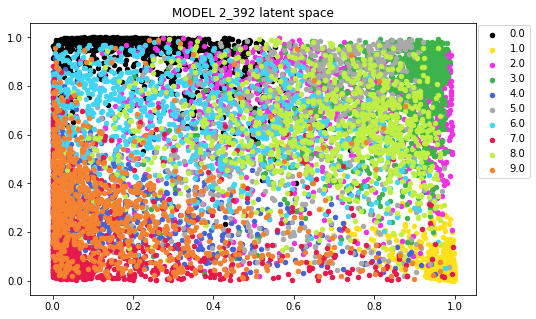

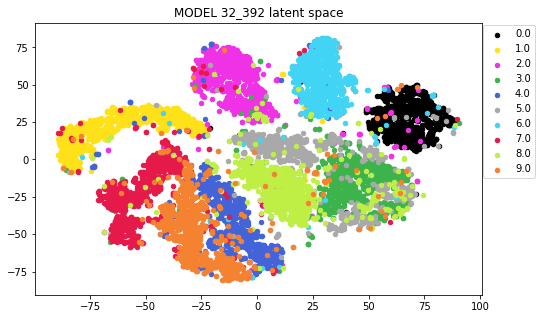

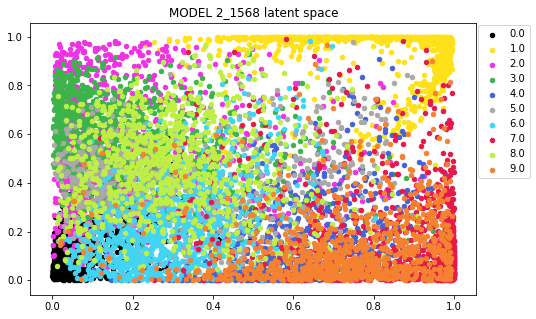

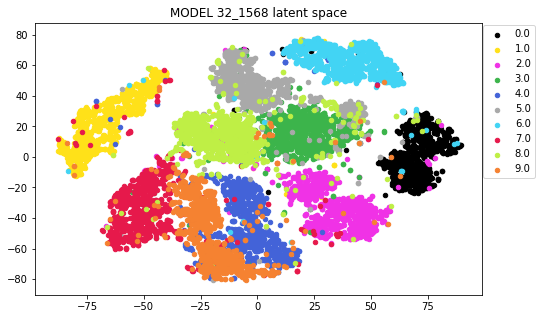

In [15]:
dots_amount=10000
for m in models:
#     X = models[m].encode(data[:dots_amount, :, :, :])
    X = models[m].encode(plot_data[:dots_amount])
    if m[:1] != '2':
        X = TSNE(n_components=2, random_state=0).fit_transform(X)
    x = [float(i[0]) for i in X]
    y = [float(i[1]) for i in X]
#     l = train_loader.dataset.targets[:dots_amount].numpy()
    l = test_loader_to_plot.dataset.targets[:dots_amount].numpy()

    latent_code = pd.DataFrame([x, y, l]).T.sort_values(2).reset_index(drop=True)
    latent_code.columns = ['x', 'y', 'label']

    fig, ax = plt.subplots(figsize=(8,5))
    for i in latent_code['label'].unique():
        df = latent_code[latent_code['label']==i]
        ax.scatter(df['x'], df['y'], color=colors[i], s=20, label=i)
    plt.legend(bbox_to_anchor=(0.63, 0.51, 0.5, 0.5))
    plt.title('MODEL {} latent space'.format(m))

# MIRROR
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = True
- mode = mirror

In [16]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='mirror', elementwise=True)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='mirror', elementwise=True)

Train Epoch: 1 [00000/60000] 2_392: 0.238131 32_392: 0.199730 2_1568: 0.234003 32_1568: 0.197919
Train Epoch: 1 [30000/60000] 2_392: 0.231398 32_392: 0.156462 2_1568: 0.229822 32_1568: 0.144122
Train Epoch: 1 [60000/60000] 2_392: 0.229104 32_392: 0.149399 2_1568: 0.223957 32_1568: 0.135305
Test set:
2_392: loss: 0.2258
32_392: loss: 0.1581
2_1568: loss: 0.2229
32_1568: loss: 0.1449

Train Epoch: 2 [00000/60000] 2_392: 0.232025 32_392: 0.184562 2_1568: 0.229127 32_1568: 0.172884
Train Epoch: 2 [30000/60000] 2_392: 0.218634 32_392: 0.162719 2_1568: 0.215101 32_1568: 0.149360
Train Epoch: 2 [60000/60000] 2_392: 0.222005 32_392: 0.142032 2_1568: 0.220828 32_1568: 0.128349
Test set:
2_392: loss: 0.2246
32_392: loss: 0.1497
2_1568: loss: 0.2217
32_1568: loss: 0.1349

Train Epoch: 3 [00000/60000] 2_392: 0.221700 32_392: 0.142536 2_1568: 0.217960 32_1568: 0.127395
Train Epoch: 3 [30000/60000] 2_392: 0.218158 32_392: 0.137499 2_1568: 0.216070 32_1568: 0.122498
Train Epoch: 3 [60000/60000] 2_392

In [17]:
losses_df2 = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df2['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df2['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df2['mode'].fillna('Mirror', inplace=True)
losses_df2['elementwise'].fillna('True', inplace=True)

losses_df2['test loss'] = [0.2172, 0.1252, 0.2149, 0.1101]
losses_df = pd.concat([losses_df, losses_df2], axis=0)

# GAUSSIAN
- latent_size = 2 | 32
- l_size = 392 | 1568
- ementwise = True
- mode = gaussian

In [18]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, mode='gaussian', elementwise=True)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log, mode='gaussian', elementwise=True)

Train Epoch: 1 [00000/60000] 2_392: 0.218907 32_392: 0.106979 2_1568: 0.213383 32_1568: 0.083877
Train Epoch: 1 [30000/60000] 2_392: 0.220799 32_392: 0.079292 2_1568: 0.215979 32_1568: 0.058508
Train Epoch: 1 [60000/60000] 2_392: 0.219625 32_392: 0.078089 2_1568: 0.214981 32_1568: 0.058264
Test set:
2_392: loss: 0.2134
32_392: loss: 0.0739
2_1568: loss: 0.2072
32_1568: loss: 0.0546

Train Epoch: 2 [00000/60000] 2_392: 0.217758 32_392: 0.076467 2_1568: 0.210999 32_1568: 0.057252
Train Epoch: 2 [30000/60000] 2_392: 0.206853 32_392: 0.066850 2_1568: 0.200107 32_1568: 0.049094
Train Epoch: 2 [60000/60000] 2_392: 0.216803 32_392: 0.069625 2_1568: 0.209603 32_1568: 0.051676
Test set:
2_392: loss: 0.2130
32_392: loss: 0.0687
2_1568: loss: 0.2069
32_1568: loss: 0.0507

Train Epoch: 3 [00000/60000] 2_392: 0.212112 32_392: 0.067460 2_1568: 0.206047 32_1568: 0.049166
Train Epoch: 3 [30000/60000] 2_392: 0.214203 32_392: 0.069076 2_1568: 0.208857 32_1568: 0.050612
Train Epoch: 3 [60000/60000] 2_392

In [19]:
losses_df2 = pd.DataFrame(columns=['mode', 'elementwise', 'fc1(.., l_size)', 'fc2(.., latent_size)', 'test loss'])

losses_df2['fc1(.., l_size)'] = [392, 392, 1568, 1568]
losses_df2['fc2(.., latent_size)'] = [2, 32, 2, 32]
losses_df2['mode'].fillna('Gaussian', inplace=True)
losses_df2['elementwise'].fillna('True', inplace=True)

losses_df2['test loss'] = [0.2070, 0.0428, 0.2006, 0.0321]
losses_df = pd.concat([losses_df, losses_df2], axis=0).reset_index(drop=True)

# Result

In [20]:
losses_df.at[losses_df[losses_df['mode']=='Crop'].index, 'color'] = '#B576AD'
losses_df.at[losses_df[losses_df['mode']=='Mirror'].index, 'color'] = '#B7D968'
losses_df.at[losses_df[losses_df['mode']=='Gaussian'].index, 'color'] = '#7CCCE5'

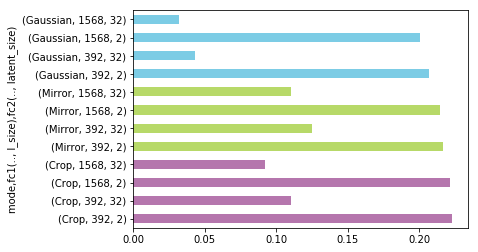

In [21]:
losses_df.set_index(['mode',
                     'fc1(.., l_size)',
                     'fc2(.., latent_size)'])['test loss'].plot(kind='barh', color=losses_df['color'])

In [22]:
pd.concat([losses_df[losses_df['test loss']==losses_df['test loss'].max()],
           losses_df[losses_df['test loss']==losses_df['test loss'].min()]], axis=0).drop('color', axis=1)

,mode,elementwise,"fc1(.., l_size)","fc2(.., latent_size)",test loss
0,Crop,False,392,2,0.2234
11,Gaussian,True,1568,32,0.0321


# Карты активаций нейронов первого слоя

In [51]:
w = models['32_392'].E.fc1.weight
print(w.size(), w.min(), w.max())

torch.Size([392, 784]) tensor(-0.2988, grad_fn=<MinBackward1>) tensor(0.2868, grad_fn=<MaxBackward1>)


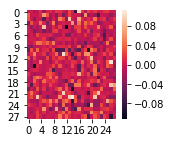

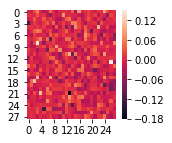

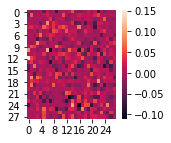

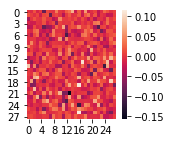

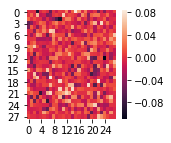

In [50]:
for i in range(5): # 10 первых фильтров
    plt.figure(figsize=(2,2))
    sns.heatmap((x1*w[i]).reshape((28,28)).detach().numpy())

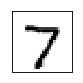

torch.Size([1, 784])

In [58]:
X_test, y_test = next(iter(test_loader))

img = X_test[:1]
plot_mnist(img.numpy(), (1, 1))
img1 = img.view(-1, 28*28)
img1.size()